In [1]:
# Image Training only.ipynb

#  This code is for training the model

# for basic file navigation and driving mount
import os
from google.colab import drive

# some basic libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# importing for basic image operations
import cv2 as cv
from PIL import Image
from PIL import ImageOps
import seaborn as sns
from datetime import datetime

# importing pretrained models
from tensorflow.keras.applications import efficientnet

# for splitting data
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# prerequisites for training models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# for selecting better metrics
from sklearn.metrics import roc_auc_score

# initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

drive.mount('/content/gdrive')

s = "target"

Mounted at /content/gdrive


In [2]:
## Image Training

TRAIN_IMG_DIR_PATH = "/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/imagens_bd/results_train/"

# converts all images for transformations
X = []
y = []

#classes = ["residential", "mixed", "commercial", "others", "industrial"]
classes = ["residential", "commercial", "others", "industrial"]
INPUT_IMG_WIDTH = 250
INPUT_IMG_HEIGHT = 350
VERTICAL = True

In [3]:
# Para Pillow 9.1.0 ou superior
try:
    from PIL import Resampling
    RESAMPLING_METHOD = Resampling.LANCZOS
except ImportError:
    RESAMPLING_METHOD = Image.LANCZOS

# memory management in python by some medium article asian woman

for class_no, img_class in enumerate(classes):

    for aug_index, img_file in enumerate(os.listdir(TRAIN_IMG_DIR_PATH + img_class + '/')):

        img = Image.open(TRAIN_IMG_DIR_PATH + img_class + '/' + img_file)
        img = ImageOps.fit(img, (INPUT_IMG_WIDTH, INPUT_IMG_HEIGHT), RESAMPLING_METHOD)

        # if you want to run on no augmentation
        np_img1 = np.array(img).astype(np.float16)
        X.append(np_img1)
        y.append(class_no)

        # if you want to run on augmentation (for every 1 image, 2 additional images)
        if aug_index % 6 == 0:
            img2 = ImageOps.mirror(img)
            np_img2 = np.array(img2).astype(np.float16)
            X.append(np_img2)
            y.append(class_no)

    print(f"{img_class} pre-processing completed!")

residential pre-processing completed!
commercial pre-processing completed!
others pre-processing completed!
industrial pre-processing completed!


In [4]:
# dataset here
X = np.asarray(X)
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
del X, y

# convert to one-hot encoded vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# problem specific stuff
if VERTICAL:
    _temp_measure = INPUT_IMG_WIDTH
    INPUT_IMG_WIDTH = INPUT_IMG_HEIGHT
    INPUT_IMG_HEIGHT = _temp_measure

history_dict = []


In [5]:
# Configuração do TensorBoard
from datetime import datetime

log_dir = "/content/gdrive/MyDrive/Colab Notebooks/TCC/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Gera histograms
    write_graph=True,   # Grava o grafo do modelo
    write_images=True,  # Salva imagens (como visualizações de filtros)
    update_freq='epoch', # Frequência de atualização
    profile_batch=0,    # Não gera perfil de desempenho
)

In [6]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB7

# Definindo a entrada do modelo
inputs = Input(shape=(INPUT_IMG_WIDTH, INPUT_IMG_HEIGHT, 3))

# Carregando a EfficientNetB7
resnet_model = EfficientNetB7(include_top=False, input_tensor=inputs)
resnet_model.trainable = False  # Congela as camadas da EfficientNet

# Adicionando camadas superiores
x = GlobalAveragePooling2D()(resnet_model.output)
x = Dropout(0.175)(x)
x = Dense(16, activation='relu')(x)  # Camada intermediária
x = Dropout(0.125)(x)
outputs = Dense(4, activation='softmax')(x)  # Camada de saída

# Definindo o modelo
model_resnet = Model(inputs=inputs, outputs=outputs)

# Compilando o modelo
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
)

# Treinando o modelo
history_resnet = model_resnet.fit(
    np.array(X_train), np.array(y_train),
    epochs=25,
    validation_data=(np.array(X_test), np.array(y_test)),
    batch_size=64,
    callbacks=[tensorboard_callback]
)

# Salvando o modelo
model_resnet.save("/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo/modelo_att(25e).keras")


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 228s 112s/step - accuracy: 0.2495 - auc: 0.4723 - loss: 1.4473 - val_accuracy: 0.5333 - val_auc: 0.7802 - val_loss: 1.2407
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 207s 114s/step - accuracy: 0.5028 - auc: 0.7395 - loss: 1.2466 - val_accuracy: 0.5333 - val_auc: 0.7909 - val_loss: 1.1458
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 178s 106s/step - accuracy: 0.5331 - auc: 0.7941 - loss: 1.1306 - val_accuracy: 0.5333 - val_auc: 0.8087 - val_loss: 1.0884
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 207s 113s/step - accuracy: 0.5663 - auc: 0.8344 - loss: 1.0413 - val_accuracy: 0.5667 - val_auc: 0.8256 - val_loss: 1.0375
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 206s 115s/step - accuracy: 0.6430 - auc: 0.8804 - loss: 0.9307 - val_accuracy: 0.6000 - val_auc: 0.8343 - val_loss: 0.9939
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 200s 113s/step - accuracy: 0.6634 - auc: 0.8973 - loss: 0.8771 - val_accuracy: 0.7000 - val_auc: 0.8509 - val_loss: 

In [ ]:
# Salvar apenas os pesos
model_resnet.save_weights("/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo/modelo_att.weights.h5")

# Para carregar:
# Recrie o modelo exatamente como definido acima e use `load_weights`
new_model = Model(inputs=inputs, outputs=outputs)
new_model.load_weights("/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo/modelo_att.weights.h5")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Análise dos resultados a partir do `history_resnet`
val_acc = history_resnet.history['val_accuracy']
train_acc = history_resnet.history['accuracy']
val_loss = history_resnet.history['val_loss']
train_loss = history_resnet.history['loss']

# Adicionando uma linha base de acurácia inicial para comparação
train_acc = [0.25] + train_acc
val_acc = [0.25] + val_acc

# Calculando a média da perda inicial e adicionando ao início para comparação
mean_loss = (val_loss[0] + train_loss[0]) / 2
train_loss = [mean_loss] + train_loss
val_loss = [mean_loss] + val_loss

# Criando DataFrame com os dados de acurácia e perda
results_df = pd.DataFrame({
    'num': range(len(train_acc)),
    'ta': train_acc,
    'va': val_acc,
    'tl': train_loss,
    'vl': val_loss
})

# Visualizando as curvas de acurácia
plt.figure(figsize=(15, 12))
sns.lineplot(data=results_df, x='num', y='ta', label='Train Accuracy')
sns.lineplot(data=results_df, x='num', y='va', label='Validation Accuracy')
plt.title("Accuracy Curves for Building Instance Classifier")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo/accuracy_plot_2.png')
plt.close()

# Visualizando as curvas de perda
plt.figure(figsize=(15, 12))
sns.lineplot(data=results_df, x='num', y='tl', label='Train Loss')
sns.lineplot(data=results_df, x='num', y='vl', label='Validation Loss')
plt.title("Loss Curves for Building Instance Classifier")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy Loss")
plt.legend()
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo/loss_plot_2.png')
plt.close()


In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB7

# Definindo a entrada do modelo
inputs = Input(shape=(INPUT_IMG_WIDTH, INPUT_IMG_HEIGHT, 3))

# Carregando a EfficientNetB7
resnet_model = EfficientNetB7(include_top=False, input_tensor=inputs)
resnet_model.trainable = False  # Congela as camadas da EfficientNet

# Adicionando camadas superiores
x = GlobalAveragePooling2D()(resnet_model.output)
x = Dropout(0.175)(x)
x = Dense(16, activation='relu')(x)  # Camada intermediária
x = Dropout(0.125)(x)
outputs = Dense(4, activation='softmax')(x)  # Camada de saída

# Definindo o modelo
model_resnet = Model(inputs=inputs, outputs=outputs)

# Compilando o modelo
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
)

# Treinando o modelo
history_resnet = model_resnet.fit(
    np.array(X_train), np.array(y_train),
    epochs=5,
    validation_data=(np.array(X_test), np.array(y_test)),
    batch_size=64,
    callbacks=[tensorboard_callback]
)

# Salvando o modelo
model_resnet.save("/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo/modelo_att_teste(10e).keras")


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 262s 127s/step - accuracy: 0.3291 - auc: 0.5197 - loss: 1.3852 - val_accuracy: 0.5000 - val_auc: 0.7544 - val_loss: 1.2311
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 170s 104s/step - accuracy: 0.4332 - auc: 0.7170 - loss: 1.2583 - val_accuracy: 0.5667 - val_auc: 0.7920 - val_loss: 1.1351
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 211s 113s/step - accuracy: 0.5459 - auc: 0.8246 - loss: 1.1028 - val_accuracy: 0.5667 - val_auc: 0.7917 - val_loss: 1.0765
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 211s 115s/step - accuracy: 0.5866 - auc: 0.8379 - loss: 1.0211 - val_accuracy: 0.5667 - val_auc: 0.7963 - val_loss: 1.0602
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 197s 116s/step - accuracy: 0.5687 - auc: 0.8563 - loss: 0.9406 - val_accuracy: 0.6000 - val_auc: 0.8019 - val_loss: 1.0416


In [ ]:
from datetime import datetime
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB7
import tensorflow as tf
import numpy as np

with strategy.scope():

    # Usando a EfficientNetB7 pré-treinada
    resnet_model = EfficientNetB7(input_shape=(INPUT_IMG_WIDTH, INPUT_IMG_HEIGHT, 3), include_top=False)

    # Congelando as camadas base, pois já estão pré-treinadas
    resnet_model.trainable = False

    # Criando o modelo sequencial com uma ativação `relu` na camada intermediária
    model_resnet = Sequential([
        resnet_model,
        GlobalAveragePooling2D(),
        Dropout(0.175),
        Dense(16, activation='relu'),  # Alteração para `relu` na camada intermediária
        Dropout(0.125),
        Dense(4, activation='softmax')  # Camada final com `softmax` para saída de classes
    ])

    # Compilando o modelo
    model_resnet.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
    )

    # Treinando o modelo
    history_resnet = model_resnet.fit(
        np.array(X_train),
        np.array(y_train),
        epochs=10,
        validation_data=(np.array(X_test), np.array(y_test)),
        batch_size=64,
        callbacks=[tensorboard_callback]
    )
    print("----------------------------------------------------")

    # Salvando o histórico do treinamento
    history_dict.append(history_resnet)

# Salvando o modelo
model_resnet.save("/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo/modelo_att(10e).keras")

# Análise dos resultados

val_acc = history_dict[0].history['val_accuracy']
train_acc = history_dict[0].history['accuracy']
val_loss = history_dict[0].history['val_loss']
train_loss = history_dict[0].history['loss']

# random probability of prediction
train_acc = [0.25] + train_acc
val_acc = [0.25] + val_acc

# starting assumption to have mean of loss of first two
mean_loss = (val_loss[0] + train_loss[0]) / 2
train_loss = [mean_loss] + train_loss
val_loss = [mean_loss] + val_loss

import pandas as pd
results_df = pd.DataFrame([train_acc, val_acc, train_loss, val_loss]).rename({0: 'ta', 1: 'va', 2: 'tl', 3: 'vl'}).T.reset_index().rename(columns={'index': 'num'})
results_df.head()

plt.figure(figsize=(15, 12))
sns.lineplot(data=results_df, x='num', y='ta',)
sns.lineplot(data=results_df, x='num', y='va',)
plt.title("Accuracy Curves obtained while training Building Instance Classifier")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (Metric)")
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo/accuracy_plot.png')
plt.close()

plt.figure(figsize=(15, 12))
sns.lineplot(data=results_df, x='num', y='tl',)
sns.lineplot(data=results_df, x='num', y='vl',)
plt.title("Loss Curves obtained while training Building Instance Classifier")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy (Loss)")
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo/loss_plot.png')
plt.close()


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 262s 127s/step - accuracy: 0.3750 - auc: 0.6340 - loss: 1.3231 - val_accuracy: 0.5333 - val_auc: 0.7669 - val_loss: 1.1494
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 225s 105s/step - accuracy: 0.4848 - auc: 0.7807 - loss: 1.1345 - val_accuracy: 0.5667 - val_auc: 0.7998 - val_loss: 1.0777
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 219s 124s/step - accuracy: 0.5204 - auc: 0.8230 - loss: 1.0399 - val_accuracy: 0.6000 - val_auc: 0.8167 - val_loss: 1.0264
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 200s 118s/step - accuracy: 0.5308 - auc: 0.8423 - loss: 0.9769 - val_accuracy: 0.6333 - val_auc: 0.8380 - val_loss: 0.9833
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 197s 115s/step - accuracy: 0.6553 - auc: 0.8911 - loss: 0.8824 - val_accuracy: 0.7000 - val_auc: 0.8385 - val_loss: 0.9733
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 191s 108s/step - accuracy: 0.6605 - auc: 0.9011 - loss: 0.8431 - val_accuracy: 0.6000 - val_auc: 0.8296 - val_loss: 0.9902
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 201s 104s/

* TensorBoard

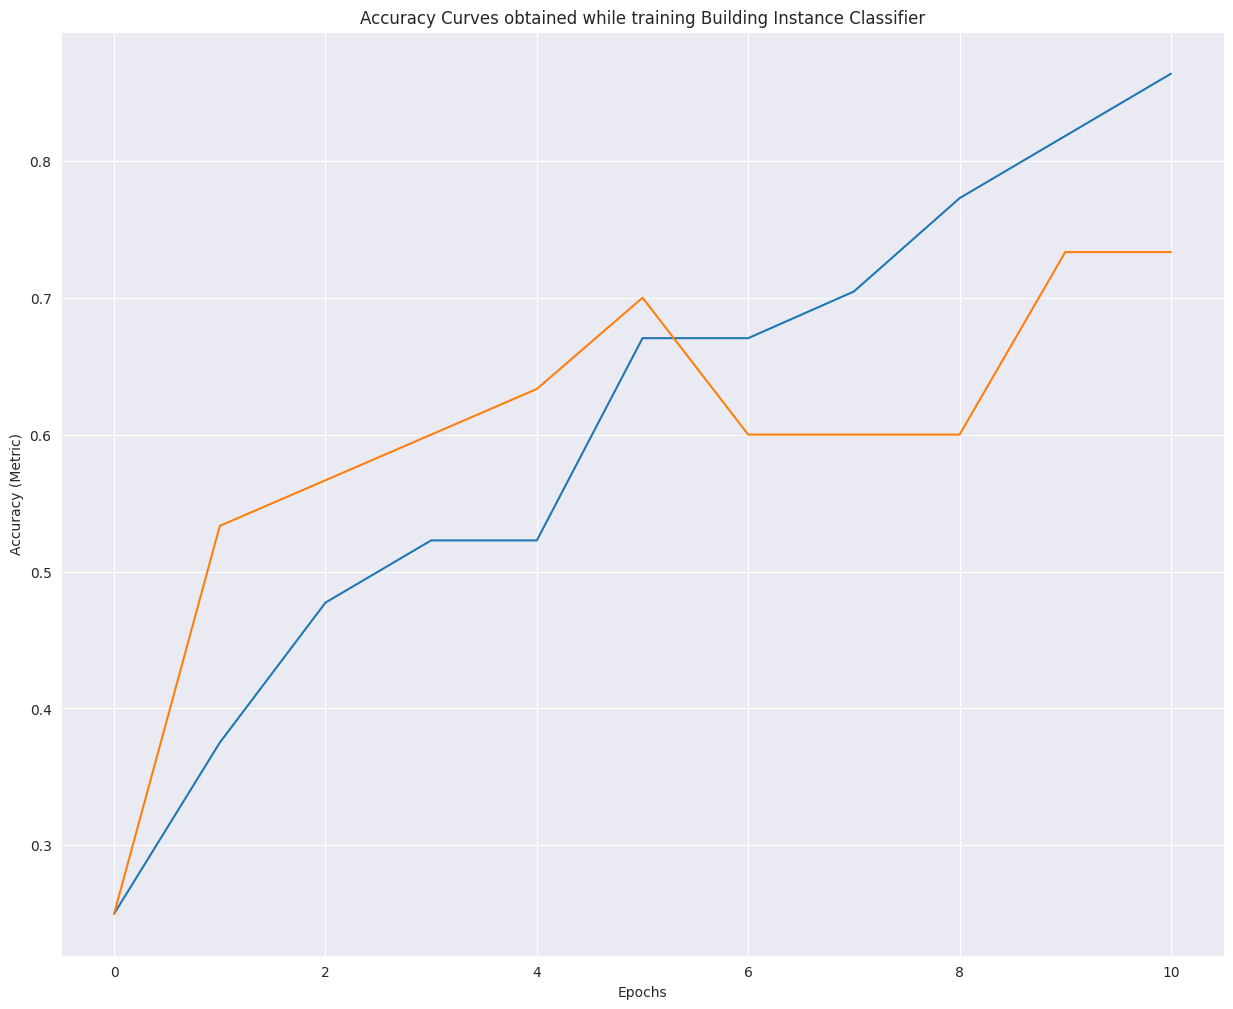

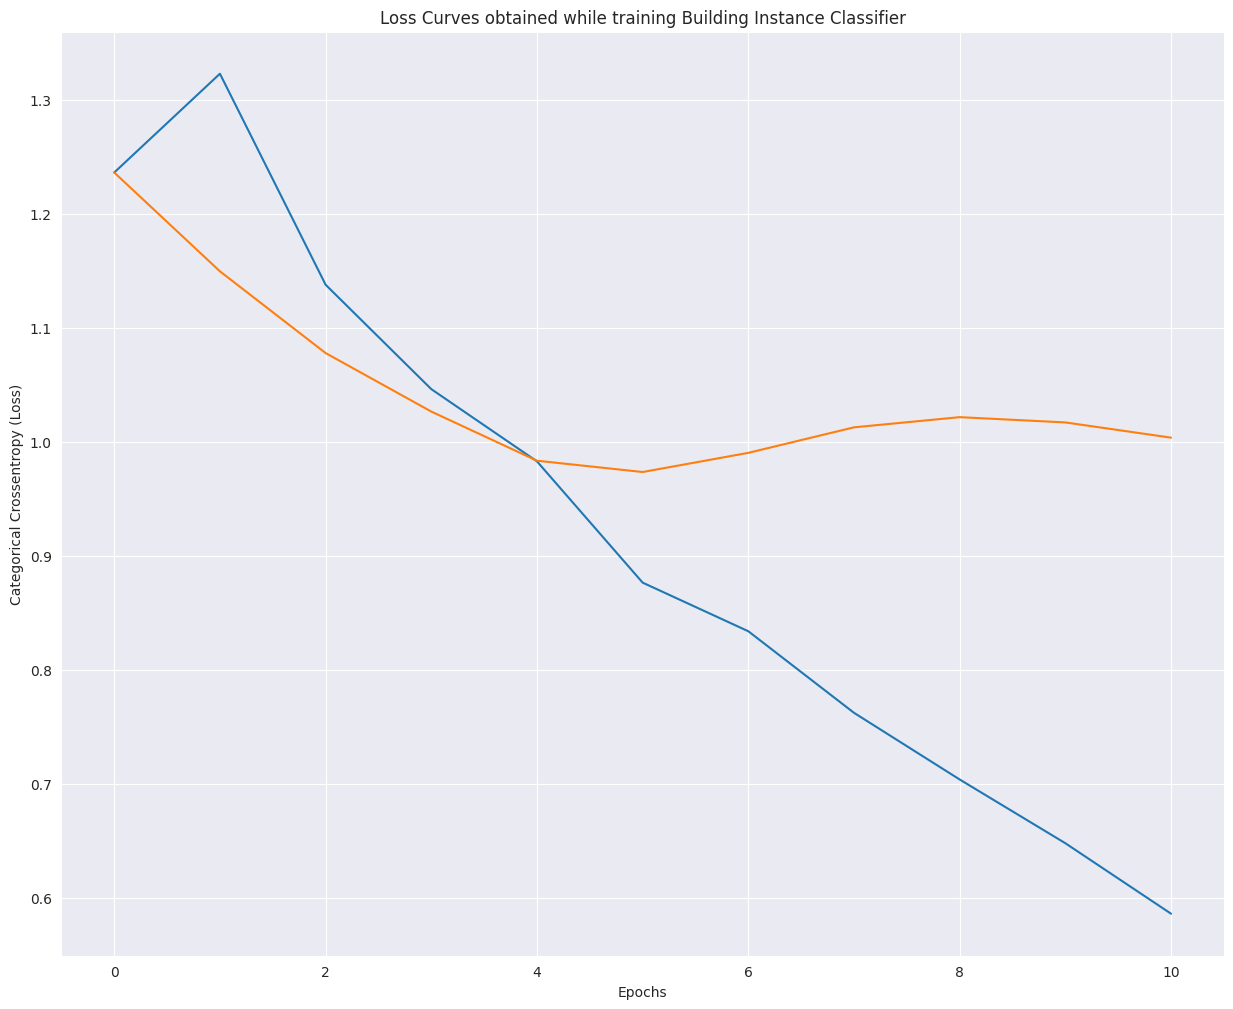

In [ ]:
# Análise dos resultados

val_acc = history_dict[0].history['val_accuracy']
train_acc = history_dict[0].history['accuracy']
val_loss = history_dict[0].history['val_loss']
train_loss = history_dict[0].history['loss']

# random probability of prediction
train_acc = [0.25] + train_acc
val_acc = [0.25] + val_acc

# starting assumption to have mean of loss of first two
mean_loss = (val_loss[0] + train_loss[0]) / 2
train_loss = [mean_loss] + train_loss
val_loss = [mean_loss] + val_loss

import pandas as pd
results_df = pd.DataFrame([train_acc, val_acc, train_loss, val_loss]).rename({0: 'ta', 1: 'va', 2: 'tl', 3: 'vl'}).T.reset_index().rename(columns={'index': 'num'})
results_df.head()

sns.set_style('darkgrid')
plt.figure(figsize=(15, 12))
sns.lineplot(data=results_df, x='num', y='ta',)
sns.lineplot(data=results_df, x='num', y='va',)
plt.title("Accuracy Curves obtained while training Building Instance Classifier")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (Metric)")
plt.show()

sns.set_style('darkgrid')
plt.figure(figsize=(15, 12))
sns.lineplot(data=results_df, x='num', y='tl',)
sns.lineplot(data=results_df, x='num', y='vl',)
plt.title("Loss Curves obtained while training Building Instance Classifier")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy (Loss)")
plt.show()